# The Project #
1. This is a project with minimal scaffolding. Expect to use the the discussion forums to gain insights! It’s not cheating to ask others for opinions or perspectives!
2. Be inquisitive, try out new things.
3. Use the previous modules for insights into how to complete the functions! You'll have to combine Pillow, OpenCV, and Pytesseract
4. There are hints provided in Coursera, feel free to explore the hints if needed. Each hint provide progressively more details on how to solve the issue. This project is intended to be comprehensive and difficult if you do it without the hints.

### The Assignment ###
Take a [ZIP file](https://en.wikipedia.org/wiki/Zip_(file_format)) of images and process them, using a [library built into python](https://docs.python.org/3/library/zipfile.html) that you need to learn how to use. A ZIP file takes several different files and compresses them, thus saving space, into one single file. The files in the ZIP file we provide are newspaper images (like you saw in week 3). Your task is to write python code which allows one to search through the images looking for the occurrences of keywords and faces. E.g. if you search for "pizza" it will return a contact sheet of all of the faces which were located on the newspaper page which mentions "pizza". This will test your ability to learn a new ([library](https://docs.python.org/3/library/zipfile.html)), your ability to use OpenCV to detect faces, your ability to use tesseract to do optical character recognition, and your ability to use PIL to composite images together into contact sheets.

Each page of the newspapers is saved as a single PNG image in a file called [images.zip](./readonly/images.zip). These newspapers are in english, and contain a variety of stories, advertisements and images. Note: This file is fairly large (~200 MB) and may take some time to work with, I would encourage you to use [small_img.zip](./readonly/small_img.zip) for testing.

Here's an example of the output expected. Using the [small_img.zip](./readonly/small_img.zip) file, if I search for the string "Christopher" I should see the following image:
![Christopher Search](./readonly/small_project.png)
If I were to use the [images.zip](./readonly/images.zip) file and search for "Mark" I should see the following image (note that there are times when there are no faces on a page, but a word is found!):
![Mark Search](./readonly/large_project.png)

Note: That big file can take some time to process - for me it took nearly ten minutes! Use the small one for testing.

### Hint 1
To access the newspapers in the zipfile, you must first use the Zipfile library to open the zipfile then iterate through the objects (newspapers) in the zipfile using .infolist(). Try and write a simple routine to just go through the zipfile, printing out the name of the file as well as using display(). Remember that the PIL.Image library can .open() files, and that items in .infolist() in the zipfile each appear to Python just as if they were a file (these are called "file-like" objects).

### Hint 2
You can spend a lot of time converting between PIL.Image files and byte arrays, but you don't have to. Why not just store the PIL.Image objects in a global data structure, maybe a list or a dictionary indexed by name? Then you can further process this data structure, by adding in information such as the text detected on the pages or the bounding boxes behind faces. Come to think of it, a list of dictionary objects, where each entry in the list would have the PIL image, the bounding boxes, and the text discovered on the page, would be a handy way to store this data.

### Hint 3
A quick reminder - in Python all strings are just like lists of characters. Kind of (remember they are immutable lists - more like tuples!). But this means you can use the in keyword to find substrings really easily. So the following statement will return True if the substring is matched: if "Christopher" in my_text.

### Hint 4
Creating the contact sheet can be a bit of a pain. But you can resize images without having to worry about the aspect ratio if you use the PIL.Image.thumbnail function. I used it when creating out the output images, maybe you should too! And check out the lecture on the contact sheet, you want to be careful that you don't "walk off" the end of the images when creating a row (or column).

image2string a-0.png ......
image2string a-1.png ......
image2string a-2.png ......
image2string a-3.png ......
image2string a-0.png done!
image2string a-1.png done!
image2string a-2.png done!
image2string a-3.png done!
image2string a-0.png ......
image2string a-1.png ......
image2string a-10.png ......
image2string a-11.png ......
image2string a-12.png ......image2string a-13.png ......

image2string a-2.png ......
image2string a-3.png ......
image2string a-13.png done!
image2string a-4.png ......
image2string a-12.png done!
image2string a-5.png ......
image2string a-0.png done!
image2string a-6.png ......
image2string a-11.png done!
image2string a-7.png ......
image2string a-7.png done!
image2string a-8.png ......
image2string a-6.png done!
image2string a-9.png ......
image2string a-10.png done!
image2string a-1.png done!
image2string a-9.png done!
image2string a-8.png done!
image2string a-4.png done!
image2string a-2.png done!
image2string a-5.png done!
image2string a-3.png done!




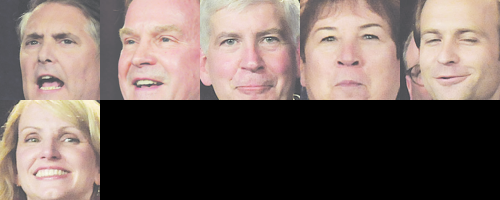

Results found in a-3.png


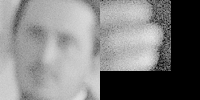



Performing text search for Mark

Results found in a-0.png


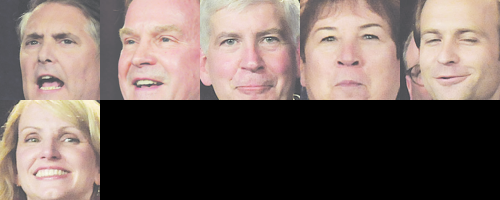

Results found in a-1.png


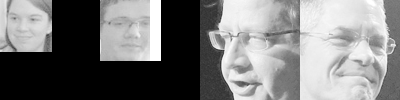

Results found in a-10.png
But there were no faces in that file!
Results found in a-13.png


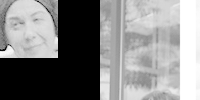

Results found in a-2.png


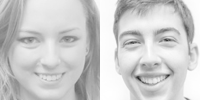

Results found in a-3.png


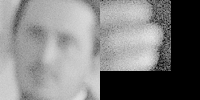

Results found in a-8.png
But there were no faces in that file!


In [3]:
import zipfile

from PIL import Image
from PIL import ImageDraw
import pytesseract
import cv2 as cv
import numpy as np
import math
import concurrent.futures


# NOTE 1
# ======
#
# If you are running on a PC at home and not on coursera servers then bump this up if you have a multi-core processor
# I set this to 8 on my own machine which makes the whole project execute in about 6 minutes.
NUM_CORES=1


DEFAULT_THRESHOLD   = 1.35
THUMBSIZE           = 100
NUM_CONTACT_IMG     = 5
THUMBNAIL_THRESHOLD = 1.05



# loading the face detection classifier
face_cascade = cv.CascadeClassifier('readonly/haarcascade_frontalface_default.xml')


# NOTE 2
# ======
#
# Tesseract installation (for my PC)
#
# If you are running on a PC at home and not on coursera servers you might need the following line commented in. Note that
# you might also need to change the path.
#
#pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"



# Part 1 - Read and process the zip file


def read_zip_file(f):
    rv=[]
    zfile = zipfile.ZipFile(f)
    for finfo in zfile.infolist():
        with zfile.open(finfo) as file:
            img = Image.open(file)
            imageData=img.getdata()
            rv.append([finfo.filename, img])

    return rv

# Helper function to speed things up a bit on my pc
def concurrent_mapper(fn, col, max_workers=NUM_CORES):
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        future = executor.map(fn, col)
    return list(future)

# Mapper to extract text from the grayscale image
def convert_image2string(x):
    print("image2string {} ......".format(x[0]))
    x.append(pytesseract.image_to_string(x[1]))
    print("image2string {} done!".format(x[0]))
    return x



## Part 2- Search


def show_rects(faces, img):
    '''
    Given a set of bounding rectangles and an image, return a modified image with the bounding rectangles highlighted
    in red.
    '''
    rv_img=img.copy()
    drawing=ImageDraw.Draw(rv_img)
    for x,y,w,h in faces:
        drawing.rectangle((x,y,x+w,y+h), outline="red")
    return rv_img 

def detect_faces(img, threshold):
    '''
    Fiven an image and a threshold, detect the bounding rectangles of faces on the image.
    Return as an np.appay
    '''
    npa=np.array(img)
    faces=face_cascade.detectMultiScale(npa, threshold)
    return faces

def face2crop(face):
    '''
    convert a face co-ords tuple to a crop co-ords tuple
    '''
    return [face[0], face[1], face[0] + face[2], face[1] + face[3]]

def get_face_images(img, threshold):
    face_images=[]
    faces=detect_faces(img, threshold)
#    display(show_rects(faces, img))
    for face in faces:
        face_img=img.crop(face2crop(face))
        face_img_faces = detect_faces(face_img, THUMBNAIL_THRESHOLD)
        if len(face_img_faces) > 0:
            face_images.append(face_img)
    return face_images

def thumbnailify(img, size_tup=(THUMBSIZE, THUMBSIZE)):
    tn_img = img.copy()
    tn_img.thumbnail(size_tup)
    rv_img=blank_img=Image.new('RGB', (THUMBSIZE, THUMBSIZE), color = 'black')
    rv_img.paste(tn_img)
    return rv_img

def get_blank_contact_sheet(num_images):
    if num_images < 1:
        return None
    else:
        height = math.ceil(num_images / NUM_CONTACT_IMG)
        width = min(NUM_CONTACT_IMG, num_images)
        return Image.new('RGB', (THUMBSIZE * width, THUMBSIZE * height), color = 'black')
    
def add_to_contact_sheet(cs_img, img_list):
    x = 0
    y = 0
    for img in img_list:
        cs_img.paste(img,[THUMBSIZE * x, THUMBSIZE * y])
        x += 1
        if x > (NUM_CONTACT_IMG - 1):
            x = 0
            y += 1

def create_contact_sheet(thumb_list):
    cs_img = get_blank_contact_sheet(len(thumb_list))
    add_to_contact_sheet(cs_img, thumb_list)
    return cs_img

def text_search(term, p_zifdat, threshold=DEFAULT_THRESHOLD):
    print("\n\nPerforming text search for {}".format(term))
    print("===========================================\n")
    search_list=[x for x in p_zifdat if term in x[2]]
    for entry in search_list:
        print("Results found in {}".format(entry[0]))
        thumb_list = list(map(thumbnailify, get_face_images(entry[1], threshold)))
        if thumb_list:
            display(create_contact_sheet(thumb_list))
        else:
            print("But there were no faces in that file!")
            

def main():

    zifdat_small=read_zip_file("readonly/small_img.zip")
    zifdat=read_zip_file("readonly/images.zip")

    if NUM_CORES>1:
        zifdat_small=concurrent_mapper(convert_image2string, zifdat_small)
        zifdat=concurrent_mapper(convert_image2string, zifdat)
    else:
        zifdat_small=list(map(convert_image2string, zifdat_small))
        zifdat=list(map(convert_image2string, zifdat))
    
    text_search("Christopher", zifdat_small)

    text_search("Mark", zifdat)
    

main()